# ICESAT-2 ATL08 Canopy Height
## Overview

This tutorial shows how to get started with ICESAT-2/ATLAS L3A Land and Vegetation Height ([ATL08](https://doi.org/10.5067/ATLAS/ATL08.006)) subsets using [NASA’s Harmony Services](https://harmony.earthdata.nasa.gov/) . Please refer to the data [user guide](https://nsidc.org/sites/default/files/documents/user-guide/atl08-v006-userguide.pdf) and the [ATBD](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl08_atbd_v006_0.pdf) for more information about the data product. The Harmony API allows seamless access and production of analysis-ready Earth observation data across different DAACs by enabling cloud-based spatial, temporal, and variable subsetting and data conversions. The ICESAT-2/ATL08 dataset is available from the Harmony API.

```{admonition} Learning Objectives
- Use [NASA’s Harmony Services](https://harmony.earthdata.nasa.gov/) to retrieve the ICESaT-2 ATL08 dataset. The Harmony API allows access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data file.
- Compute summaries of canopy height in the study area.
```


In [1]:
import h5py
import requests as re
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob
from matplotlib.colors import ListedColormap
from harmony import Client, Collection, Request
import seaborn as sns
from os import path
sns.set(style='whitegrid')

## Authentication
NASA Harmony API requires [NASA Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/). You can use the [earthaccess](https://nsidc.github.io/earthaccess/) Python library to set up authentication. Alternatively, you can also login to harmony_client directly by passing EDL authentication as the following in the Jupyter Notebook itself:
```bash
harmony_client = Client(auth=("your EDL username", "your EDL password"))
```

## Create Harmony Client Object
First, we create a Harmony Client object. If you are passing the EDL authentication, please do as shown above with the `auth` parameter.

In [2]:
harmony_client = Client()

## Retrieve Concept ID
Now, let’s retrieve the `Concept ID` of the GEDI L4A dataset. The `Concept ID` is NASA Earthdata’s unique ID for its dataset.

In [3]:
# ATL08 DOI 
doi = '10.5067/ATLAS/ATL08.006'

# CMR API base url
doisearch = f'https://cmr.earthdata.nasa.gov/search/collections.json?doi={doi}' 
concept_id = re.get(doisearch).json()['feed']['entry'][0]['id']
concept_id

'C2613553260-NSIDC_CPRD'

## Define Request Parameters

Let’s create a Harmony Collection object with the `concept_id` retrieved above. We will also define temporal range.

In [5]:
collection = Collection(id=concept_id)
# icesat2 tracks
tracks = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
temporal_range = {'start': datetime(2019, 4, 17), 
                  'stop': datetime(2023, 3, 31)}

We will use the spatial extent of the [Reserva Florestal Adolpho Ducke](https://ppbio.inpa.gov.br/en/Sites/RFAD), a forest reserve near Manaus, Brazil, provided as a GeoJSON file at `assets/reserva_ducke.json`. Let’s open and plot this file.

In [6]:
poly_json = 'assets/reserva_ducke.json'
poly = gpd.read_file(poly_json) 
poly.explore(color='red',  fill=False)

## Create and Submit Harmony Request
Now, we can create a Harmony request with variables, temporal range, and bounding box and submit the request using the Harmony client object. We will use the `download_all` method, which uses a multithreaded downloader and returns a [concurrent future](https://docs.python.org/3/library/concurrent.futures.html). Futures are asynchronous and let us use the downloaded file as soon as the download is complete while other files are still being downloaded.

In [15]:
request = Request(collection=collection, 
                  temporal=temporal_range,
                  shape=poly_json,
                  ignore_errors=True)

# submit harmony request, will return job id
subset_job_id = harmony_client.submit(request)

print(f'Processing job: {subset_job_id}')

print(f'Waiting for the job to finish')
results = harmony_client.result_json(subset_job_id, show_progress=True)

print(f'Downloading subset files...')
futures = harmony_client.download_all(subset_job_id, directory="downloads", overwrite=False)
for f in futures:
    # all subsetted files have this suffix
    if f.result().endswith('subsetted.h5'):
        print(f'Downloaded: {f.result()}')
            
print(f'Done downloading files.')

Processing job: b730fa6f-d9b7-48a4-895b-85334354c04e
Waiting for the job to finish


 [ Processing: 100% ] |###################################################| [|]


downloads/ATL08_20190515212101_07270308_006_02.h5
downloads/ATL08_20190802053135_05360414_006_02.h5
downloads/ATL08_20190814170043_07270408_006_02.h5
downloads/ATL08_20200101221512_00940614_006_01.h5
downloads/ATL08_20200414052408_02850708_006_02.h5
downloads/ATL08_20200430163100_05360714_006_02.h5
downloads/ATL08_20200513040011_07270708_006_01.h5
downloads/ATL08_20200701133446_00940814_006_01.h5
downloads/ATL08_20200811233957_07270808_006_01.h5
downloads/ATL08_20210209145940_07271008_006_01.h5
downloads/ATL08_20210412120327_02851108_006_02.h5
downloads/ATL08_20210810061923_07271208_006_01.h5
downloads/ATL08_20210928155405_00941314_006_02.h5
downloads/ATL08_20220207213911_07271408_006_01.h5
downloads/ATL08_20220427054953_05361514_006_02.h5
downloads/ATL08_20220710142258_02851608_006_02.h5
downloads/ATL08_20220727012954_05361614_006_02.h5
downloads/ATL08_20221107083847_07271708_006_01.h5
downloads/ATL08_20230108054227_02851808_006_02.h5
downloads/ATL08_20230124164943_05361814_006_02.h5


## Land Segments
ATL08 data are grouped into six ground tracks: `gt1l`, `gt1r`, `gt2l`, `gt2r`, `gt3l`, and `gt3r`. The ground tracks with names ending with `l` are strong beams, and those ending with `r` are weak beam types. The `land_segments` group within each ground track contains photon data stored as aggregates of 100 meters.

Within the `land_segments` group, the geolocation coordinates are provided in `latitude` and `longitude` variables. The variable `n_seg_ph` contains the number of photons in each segment. Let's read those variables from the subset files and put them into a geopandas dataframe.

In [15]:
latitude = []
longitude = []
n_seg_ph = []
atl08_f = glob(path.join('downloads', 'ATL08*'))
for h5_f in atl08_f:
     with h5py.File(h5_f) as hf:
        for var in list(hf.keys()):
            if var.startswith('gt'):
                latitude.extend(hf[var]['land_segments']['latitude'][:])
                longitude.extend(hf[var]['land_segments']['longitude'][:])
                n_seg_ph.extend(hf[var]['land_segments']['n_seg_ph'][:])

# read the lists into a dataframe
s_df = pd.DataFrame(list(zip(latitude,longitude,n_seg_ph)), columns=["latitude", "longitude", "n_seg_ph"])
# converting pandas dataframe into geopandas dataframe
s_gdf = gpd.GeoDataFrame(s_df, geometry=gpd.points_from_xy(s_df.longitude, s_df.latitude))
s_gdf.crs = "EPSG:4326" # WGS84 CRS
s_gdf = s_gdf[s_gdf['geometry'].within(poly.geometry[0])]    
# print the first two rows
s_gdf.head(2)

,latitude,longitude,n_seg_ph,geometry
657210,-3.002721,-59.943165,141,POINT (-59.94316 -3.00272)
657211,-3.001819,-59.943253,125,POINT (-59.94325 -3.00182)


Let's plot the land segments' location over a base map. The figure shows number of photons per land segments of the ATL08 land segments within the subset area.

In [16]:
s_gdf.explore("n_seg_ph", cmap = "YlGn", alpha=0.5, legend=True)

As you can see in the figure above, the number of photons varies from one land segment to the other.

## Canopy height metrics
Canopy height metrics for each land segment are provided within the canopy subgroup. The metrics give the cumulative distribution of relative canopy heights above the interpolated ground surface (canopy_h_metrics) and absolute heights above the WGS84 ellipsoid (`canopy_h_metrics_abs`) at the following percentiles: `10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95`.

Let's retrieve the relative canopy height metrics of one of the subset files and its track (`gt3l`). We will then compute the distance of each land segment from the first one for plotting.

In [17]:
first_h5 = atl08_f[0]
track = 'gt3l'

# reading the h5 file
with h5py.File(first_h5) as hf:
    # time
    delta_time = hf[track]['land_segments']['delta_time'][:]
    # canopy height metrics
    v = hf[track]['land_segments']['canopy']['canopy_h_metrics']
    fill_value_chm = v.attrs['_FillValue'] # fill value
    chm = v[:]

# set fill value to NaNs
chm[chm==fill_value_chm] = np.nan

# create pandas dataframe
chm_df = pd.DataFrame(data = chm, columns = list(range(100))[10::5])
# insert deltatime
chm_df.loc[:, 'delta_time'] = delta_time

# print the first two rowsdataframe
chm_df.head(2)

,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,delta_time
0,4.778725,5.220436,5.918282,7.340942,7.950821,9.204849,10.127068,10.534409,10.759117,11.483124,11.952408,13.123795,14.778336,15.993980,25.186859,30.927002,32.508316,33.627419,5.103724e+07
1,4.472343,5.787186,6.732895,8.113518,9.415642,10.016464,12.307198,13.195625,14.897011,15.656738,17.376190,19.043457,21.670708,23.355232,26.876648,27.161194,29.402855,30.062614,5.103724e+07


Now, let's plot the canopy height metrics of the land segments.

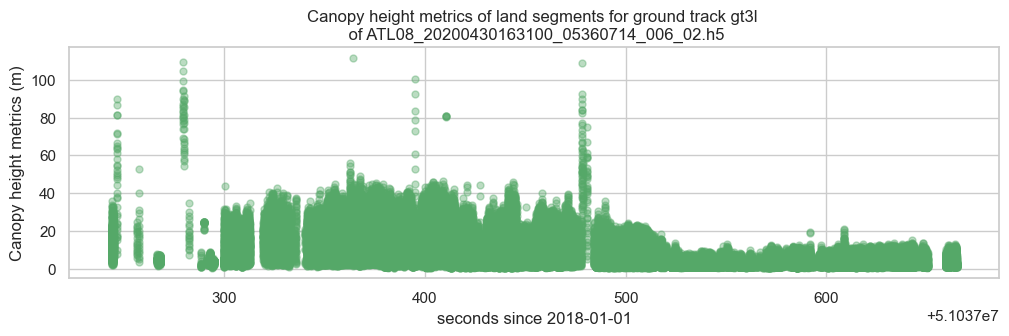

In [22]:
title=f'Canopy height metrics of land segments for ground track {track} \n of {path.basename(first_h5)}'
ax = chm_df.plot(kind='line', x='delta_time', y=chm_df.columns[:18], title=title, 
                          marker='.', linestyle='none', c='g', ms=10, alpha=0.4, legend=False, figsize=(12,3))
ax.set_xlabel("seconds since 2018-01-01")
ax.set_ylabel("Canopy height metrics (m)")
plt.show()

## Canopy/Terrain heights for geosegments
ATL08 also provides selected canopy and terrain variables for 20m geosegments (`h_canopy_20m, h_te_best_fit_20m, latitude_20m, longitude_20m`). There are five geosegments within a land segment.

## Photon classification
Photon information is provided in the signal_photons group within each ground track. Let's plot the photon height (`ph_h`) and classification (`classed_pc_flag`) of these four ATL08 files.

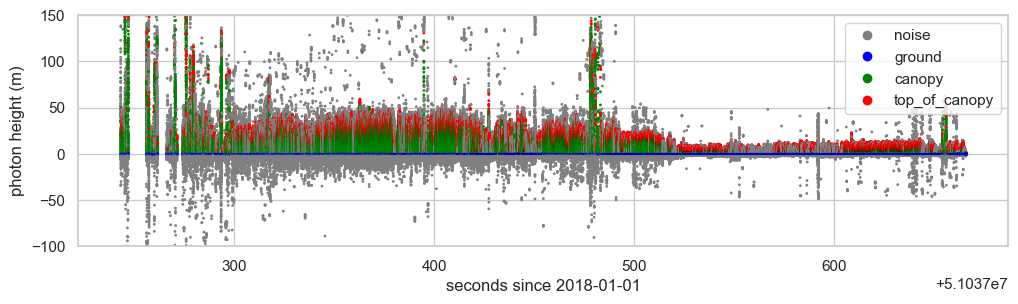

In [25]:
with h5py.File(atl08_f[0]) as hf:
    ph_h= hf[track]['signal_photons']['ph_h'][:]
    classed_pc_flag = hf[track]['signal_photons']['classed_pc_flag'][:]
    delta_time = hf[track]['signal_photons']['delta_time'][:] 
    
# photon classes
classes = ['noise', 'ground', 'canopy', 'top_of_canopy']   
colors = ListedColormap(['gray','blue','green','red'])
plt.figure(figsize=(12, 3))
scatter = plt.scatter(delta_time,ph_h,c=classed_pc_flag, cmap=colors, s=1)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.ylim(-100, 150) 
plt.xlabel("seconds since 2018-01-01")
plt.ylabel("photon height (m)")
plt.show()